In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image

2024-04-01 15:29:41.816660: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 15:29:41.816755: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 15:29:41.938883: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
breast_img = glob.glob('/kaggle/input/ns-idc-data/NS_IDC_Data/T/*/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)

/kaggle/input/ns-idc-data/NS_IDC_Data/T/0/13591_idx5_x2951_y651_class0.png
/kaggle/input/ns-idc-data/NS_IDC_Data/T/0/13666_idx5_x1151_y251_class0.png
/kaggle/input/ns-idc-data/NS_IDC_Data/T/0/13024_idx5_x551_y601_class0.png


In [4]:
len(breast_img)

20000

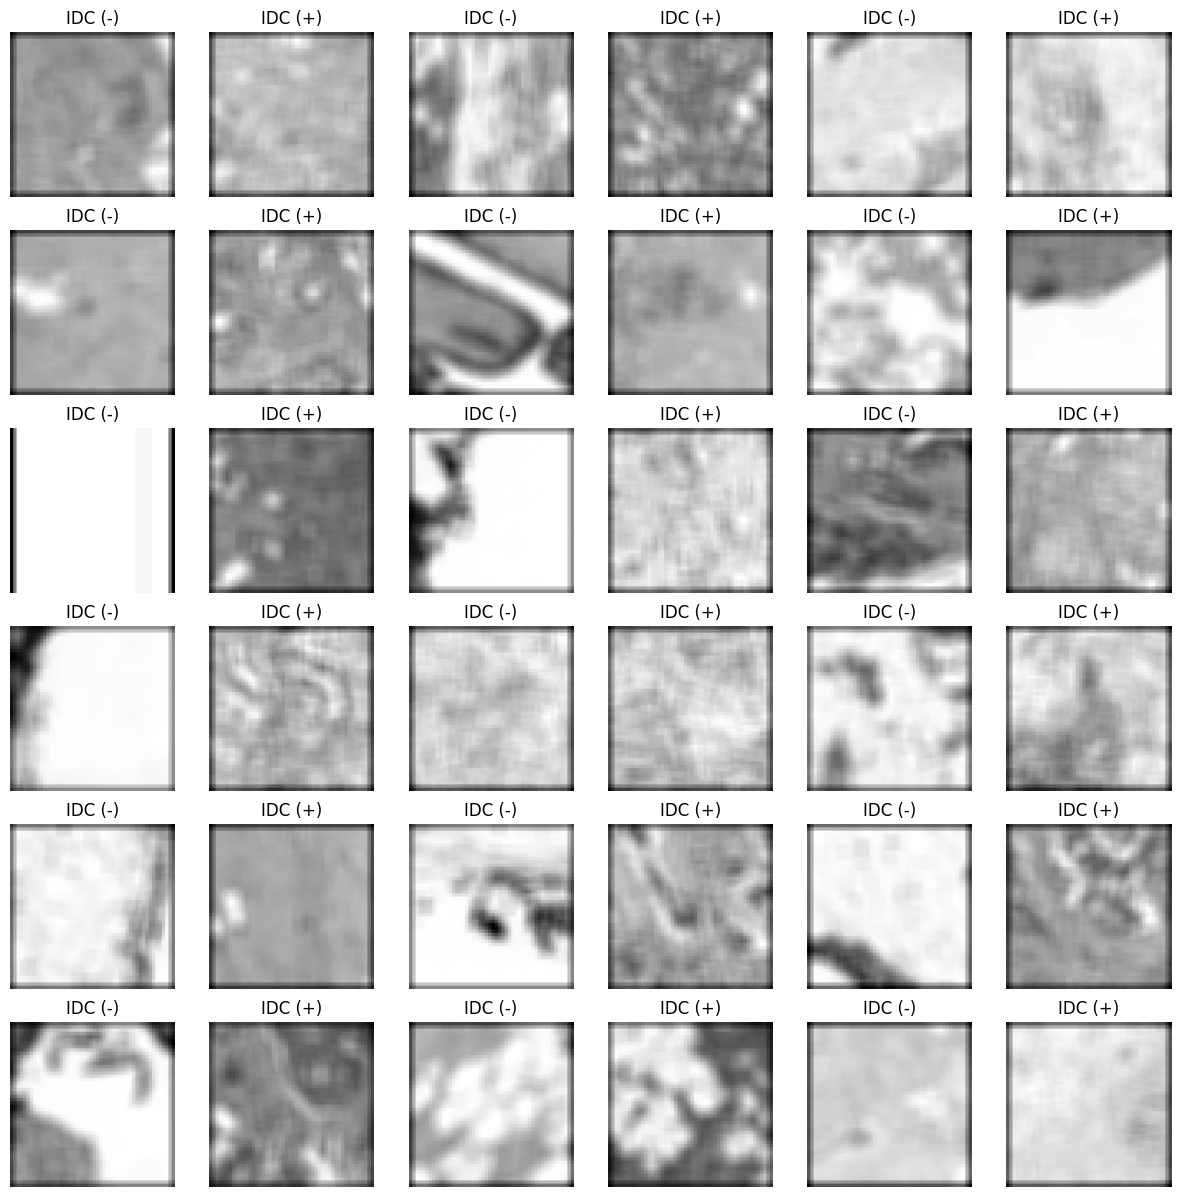

In [5]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)
    
    elif img[-5] == '1' :
        P_IDC.append(img)
        
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:
    
        img = image.load_img((N_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('IDC (-)')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:
    
        img = image.load_img((P_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1

In [6]:
y = []
for img in breast_img:
    if img.endswith('class0.png'):
        y.append(0)
    elif img.endswith('class1.png'):
        y.append(1)

print(len(y))

images_df = pd.DataFrame()
images_df["images"] = breast_img
images_df["labels"] = y
print(images_df.head())
print()

def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Image shape (Width, Height, Channels): {}'.format(a.shape))
describeData(cv2.imread(breast_img[0]),images_df["labels"])

20000
                                              images  labels
0  /kaggle/input/ns-idc-data/NS_IDC_Data/T/0/1359...       0
1  /kaggle/input/ns-idc-data/NS_IDC_Data/T/0/1366...       0
2  /kaggle/input/ns-idc-data/NS_IDC_Data/T/0/1302...       0
3  /kaggle/input/ns-idc-data/NS_IDC_Data/T/0/1026...       0
4  /kaggle/input/ns-idc-data/NS_IDC_Data/T/0/1025...       0

Total number of images: 50
Number of IDC(-) Images: 10000
Number of IDC(+) Images: 10000
Image shape (Width, Height, Channels): (50, 50, 3)


In [7]:
from sklearn.model_selection import train_test_split


# Step 1: Read the image paths and labels from the DataFrame
X_paths = images_df['images'].tolist()
y = images_df['labels'].tolist()

# Define a function to load and preprocess images
def load_images(image_paths):
    images = []
    for path in image_paths:
        image = cv2.imread(path) 
        #image = cv2.resize(image,(50, 50), interpolation = cv2.INTER_LINEAR)
        image = cv2.resize(image, (50, 50), interpolation = cv2.INTER_AREA)
        image = image / 255.0
        # Optionally, preprocess the images here (resize, normalize, etc.)
        images.append(image)
    return images

# Load images for train and test sets
X = load_images(X_paths)

In [8]:
# Step 2: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [9]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)
print("Training Data Shape:", y_train.shape)
print("Testing Data Shape:", y_test.shape)

Training Data Shape: (16000, 50, 50, 3)
Testing Data Shape: (4000, 50, 50, 3)
Training Data Shape: (16000,)
Testing Data Shape: (4000,)


# MODLING

In [12]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.models import Model

# VGG16 MODEL

In [14]:
from tensorflow.keras.applications.vgg16 import VGG16


vgg_model=VGG16(input_shape=(50,50,3),include_top=False)
x=Flatten()(vgg_model.output)
prediction=Dense(2,activation='softmax')(x)
model=Model(inputs=vgg_model.input,outputs=prediction)
#model.summary()

In [15]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 64)

Epoch 1/50
  5/250 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.5233 - loss: 0.7194 

I0000 00:00:1711986042.489993      88 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.6605 - loss: 0.6156 - val_accuracy: 0.7430 - val_loss: 0.5276
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7302 - loss: 0.5431 - val_accuracy: 0.7418 - val_loss: 0.5300
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.7377 - loss: 0.5252 - val_accuracy: 0.7610 - val_loss: 0.5106
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7490 - loss: 0.5093 - val_accuracy: 0.7558 - val_loss: 0.5060
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7666 - loss: 0.4783 - val_accuracy: 0.7538 - val_loss: 0.5076
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7912 - loss: 0.4456 - val_accuracy: 0.7558 - val_loss: 0.5135
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.8126 - loss: 0.4077 - val_accuracy: 0.7498 - val_loss: 0.5239
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8582 - loss: 0.3327 - val_accuracy: 

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


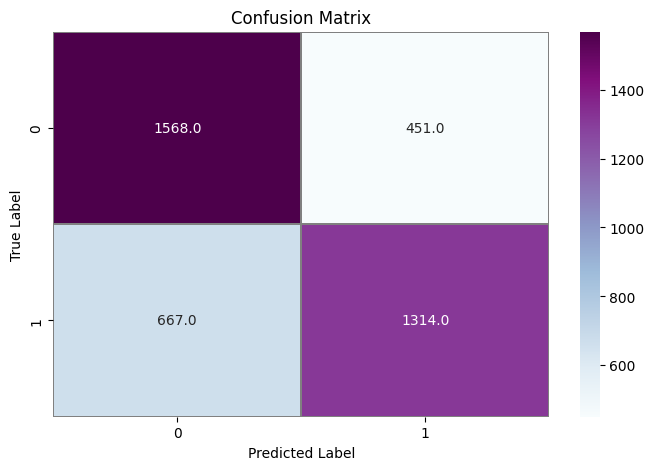

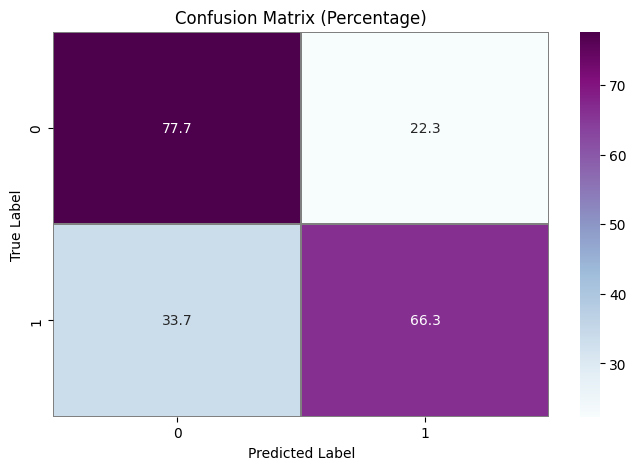

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7243 - loss: 1.9086
Test Loss: 1.9486371278762817
Test Accuracy: 0.7204999923706055


              precision    recall  f1-score   support

           0       0.70      0.78      0.74      2019
           1       0.74      0.66      0.70      1981

    accuracy                           0.72      4000
   macro avg       0.72      0.72      0.72      4000
weighted avg       0.72      0.72      0.72      4000



In [16]:
from sklearn.metrics import accuracy_score , confusion_matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = y_test 

confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print()
print()
print(classification_report(y_test, y_pred_classes))

#  VGG19 MODEL

In [17]:
from tensorflow.keras.applications import VGG19

# Load the pre-trained VGG19 model (without the top classification layer)
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the VGG19 base model
x = Flatten()(vgg_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=vgg_model.input, outputs=prediction)
#model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 64)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.6477 - loss: 0.6291 - val_accuracy: 0.7385 - val_loss: 0.5367
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.7198 - loss: 0.5557 - val_accuracy: 0.7318 - val_loss: 0.5415
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.7286 - loss: 0.5462 - val_accuracy: 0.7063 - val_loss: 0.5964
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.7358 - loss: 0.5330 - val_accuracy: 0.7370 - val_loss: 0.5392
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.7459 - loss: 0.5156 - val_accuracy: 0.7560 - val_loss: 0.5005
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.7672 - loss: 0.4912 - val_accuracy: 0.7527 - val_loss: 0.5058
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.7567 - loss: 0.5005 - val_accuracy: 0.7458 - val_loss: 0.5079
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.7760 - loss: 0.4757 - 

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


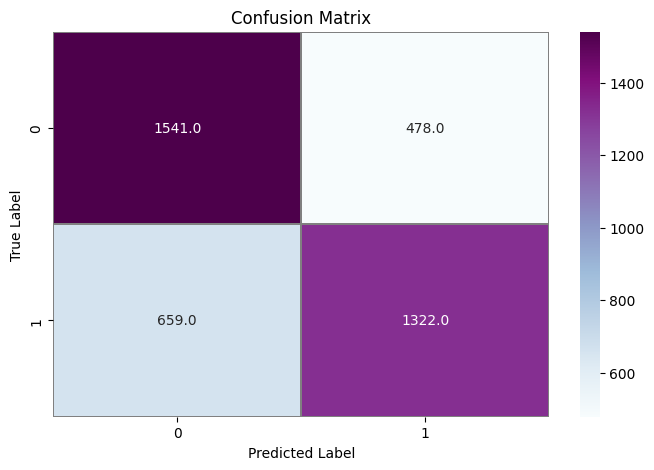

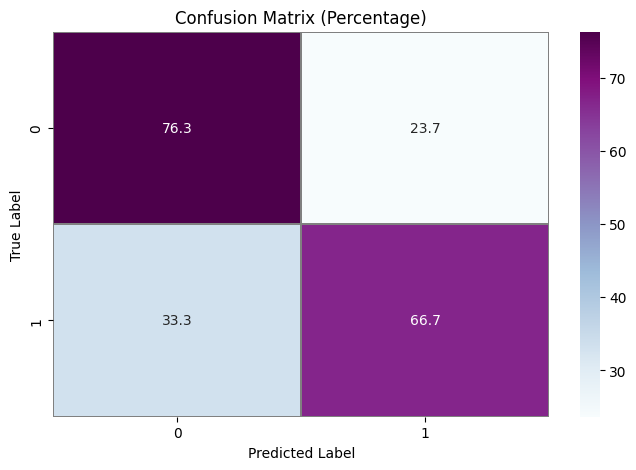

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7178 - loss: 1.6555
Test Loss: 1.6607915163040161
Test Accuracy: 0.715749979019165


              precision    recall  f1-score   support

           0       0.70      0.76      0.73      2019
           1       0.73      0.67      0.70      1981

    accuracy                           0.72      4000
   macro avg       0.72      0.72      0.71      4000
weighted avg       0.72      0.72      0.72      4000



In [19]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = y_test 

confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print()
print()
print(classification_report(y_test, y_pred_classes))

# ResNet50

In [20]:
from tensorflow.keras.applications import ResNet50

# Load the pre-trained ResNet50 model (without the top classification layer)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the ResNet50 base model
x = Flatten()(resnet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=resnet_model.input, outputs=prediction)
#model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [21]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 64)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 76s 81ms/step - accuracy: 0.6707 - loss: 0.8520 - val_accuracy: 0.5048 - val_loss: 267.1265
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.7970 - loss: 0.5265 - val_accuracy: 0.4812 - val_loss: 2.1199
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.8607 - loss: 0.3428 - val_accuracy: 0.5095 - val_loss: 14.4122
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.9071 - loss: 0.2421 - val_accuracy: 0.5320 - val_loss: 1.4752
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.9447 - loss: 0.1484 - val_accuracy: 0.6852 - val_loss: 0.8532
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.9637 - loss: 0.1002 - val_accuracy: 0.6837 - val_loss: 1.3188
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.9777 - loss: 0.0674 - val_accuracy: 0.7335 - val_loss: 0.8972
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.9708 - loss: 0.0822

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


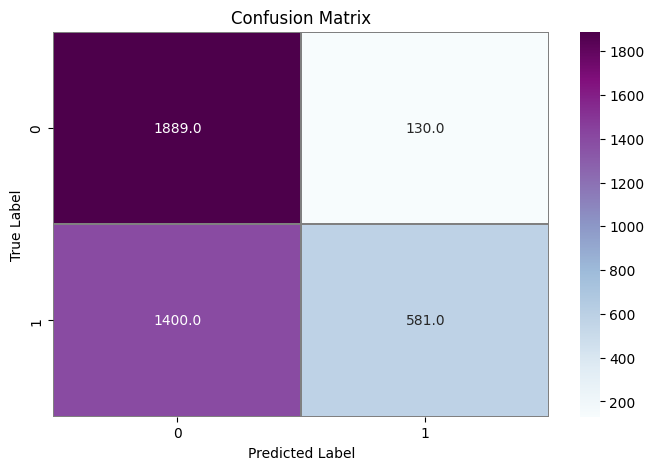

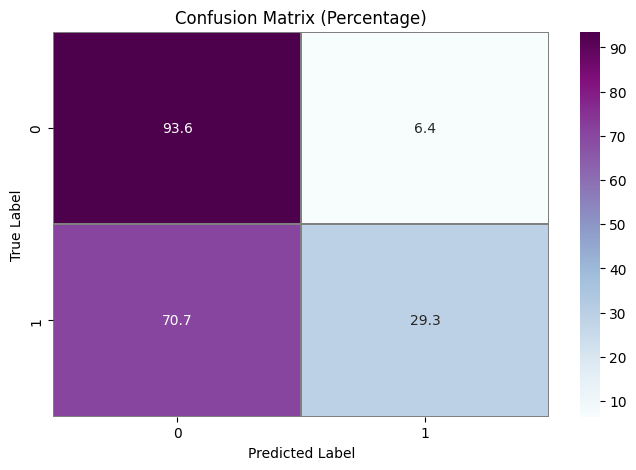

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6192 - loss: 7.8080
Test Loss: 7.634711265563965
Test Accuracy: 0.6175000071525574


              precision    recall  f1-score   support

           0       0.57      0.94      0.71      2019
           1       0.82      0.29      0.43      1981

    accuracy                           0.62      4000
   macro avg       0.70      0.61      0.57      4000
weighted avg       0.69      0.62      0.57      4000



In [22]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = y_test 

confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print()
print()
print(classification_report(y_test, y_pred_classes))

# ResNet152

In [23]:
from tensorflow.keras.applications import ResNet152


# Load the pre-trained ResNet152 model (without the top classification layer)
resnet_model = ResNet152(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the ResNet152 base model
x = Flatten()(resnet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=resnet_model.input, outputs=prediction)

#model.summary()

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [24]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 64)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 214s 202ms/step - accuracy: 0.6905 - loss: 0.8413 - val_accuracy: 0.4952 - val_loss: 4225.2979
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - accuracy: 0.7618 - loss: 0.6161 - val_accuracy: 0.5048 - val_loss: 521.3735
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 142ms/step - accuracy: 0.7898 - loss: 0.5318 - val_accuracy: 0.4805 - val_loss: 9.5605
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 139ms/step - accuracy: 0.8144 - loss: 0.4638 - val_accuracy: 0.5052 - val_loss: 0.8903
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - accuracy: 0.8495 - loss: 0.3760 - val_accuracy: 0.5602 - val_loss: 0.8291
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - accuracy: 0.9152 - loss: 0.2336 - val_accuracy: 0.7030 - val_loss: 0.7036
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 139ms/step - accuracy: 0.9537 - loss: 0.1312 - val_accuracy: 0.6480 - val_loss: 1.4407
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - accuracy: 0.9658 - l

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step


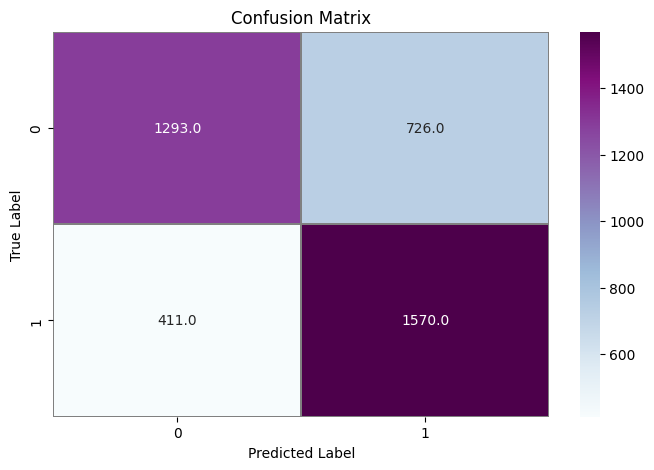

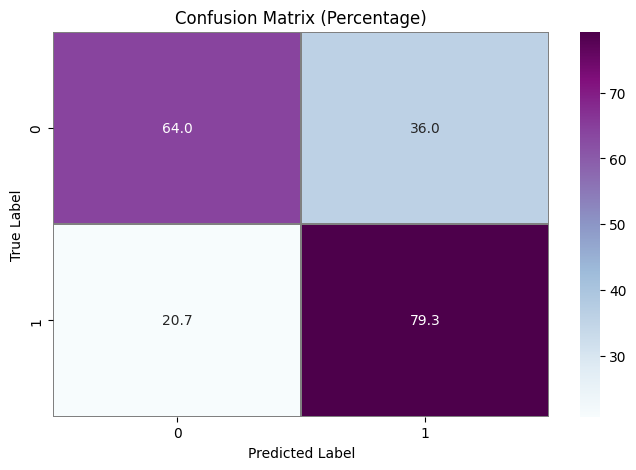

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7209 - loss: 1.4927
Test Loss: 1.4872515201568604
Test Accuracy: 0.715749979019165


              precision    recall  f1-score   support

           0       0.76      0.64      0.69      2019
           1       0.68      0.79      0.73      1981

    accuracy                           0.72      4000
   macro avg       0.72      0.72      0.71      4000
weighted avg       0.72      0.72      0.71      4000



In [25]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = y_test 

confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print()
print()
print(classification_report(y_test, y_pred_classes))

# DenseNet121 Model

In [26]:
from tensorflow.keras.applications import DenseNet121

# Load the pre-trained DenseNet121 model (without the top classification layer)
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the DenseNet121 base model
x = Flatten()(densenet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=densenet_model.input, outputs=prediction)
#model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [27]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 64)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 172s 160ms/step - accuracy: 0.6627 - loss: 0.7166 - val_accuracy: 0.6133 - val_loss: 0.7127
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.7788 - loss: 0.4897 - val_accuracy: 0.5495 - val_loss: 2.0269
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.7943 - loss: 0.4558 - val_accuracy: 0.6055 - val_loss: 0.7900
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.8266 - loss: 0.3910 - val_accuracy: 0.6735 - val_loss: 0.8360
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.8777 - loss: 0.2978 - val_accuracy: 0.7023 - val_loss: 0.7331
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.9088 - loss: 0.2250 - val_accuracy: 0.6898 - val_loss: 0.9933
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.9395 - loss: 0.1588 - val_accuracy: 0.7297 - val_loss: 0.8241
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.9472 - loss: 0.1358 

125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step


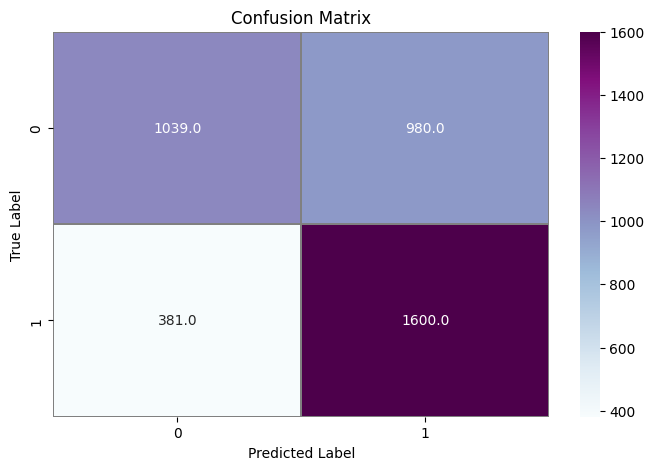

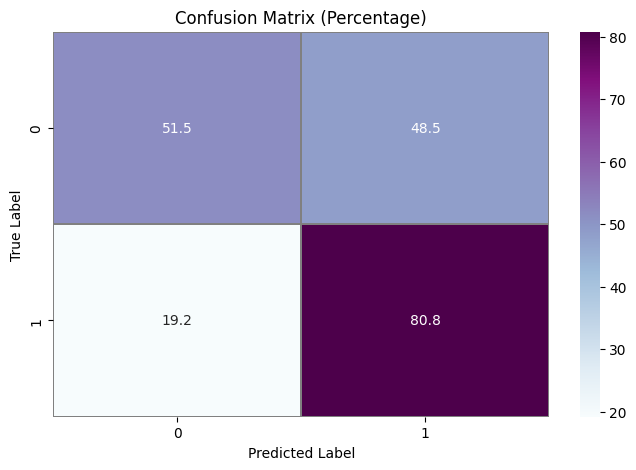

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6638 - loss: 2.3195
Test Loss: 2.356757640838623
Test Accuracy: 0.6597499847412109


              precision    recall  f1-score   support

           0       0.73      0.51      0.60      2019
           1       0.62      0.81      0.70      1981

    accuracy                           0.66      4000
   macro avg       0.68      0.66      0.65      4000
weighted avg       0.68      0.66      0.65      4000



In [28]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = y_test 

confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print()
print()
print(classification_report(y_test, y_pred_classes))

# EfficientNetB0

In [29]:
from tensorflow.keras.applications import EfficientNetB0

# Load the pre-trained EfficientNetB0 model (without the top classification layer)
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the EfficientNetB0 base model
x = Flatten()(efficientnet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=efficientnet_model.input, outputs=prediction)
#model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [30]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 64)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 111s 85ms/step - accuracy: 0.6656 - loss: 0.6764 - val_accuracy: 0.5050 - val_loss: 2.1334
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.7587 - loss: 0.5037 - val_accuracy: 0.5335 - val_loss: 9.8941
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8015 - loss: 0.4271 - val_accuracy: 0.5332 - val_loss: 0.9812
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8264 - loss: 0.3848 - val_accuracy: 0.7165 - val_loss: 0.5983
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8629 - loss: 0.3252 - val_accuracy: 0.7415 - val_loss: 0.5872
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.8885 - loss: 0.2830 - val_accuracy: 0.7365 - val_loss: 0.6265
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.9063 - loss: 0.2366 - val_accuracy: 0.7448 - val_loss: 0.6631
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.9221 - loss: 0.2009 - va

125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


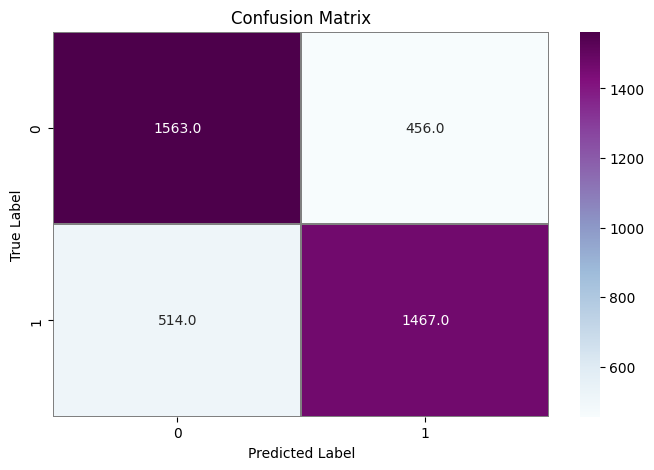

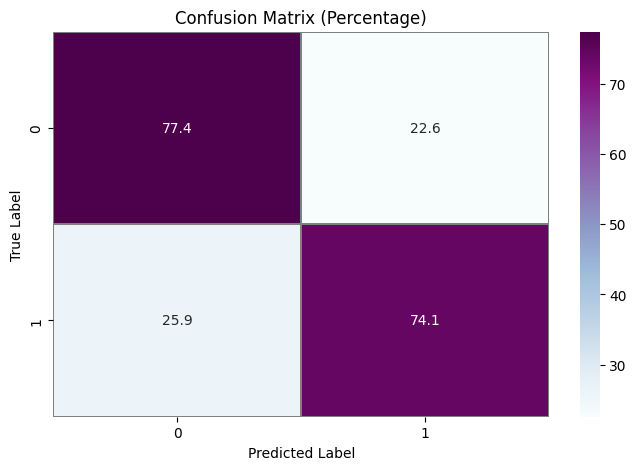

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7721 - loss: 1.2154
Test Loss: 1.2986257076263428
Test Accuracy: 0.7574999928474426


              precision    recall  f1-score   support

           0       0.75      0.77      0.76      2019
           1       0.76      0.74      0.75      1981

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



In [31]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = y_test 

confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print()
print()
print(classification_report(y_test, y_pred_classes))

# MobileNetV2 Model

In [32]:
from tensorflow.keras.applications import MobileNetV2

# Load the pre-trained MobileNetV2 model (without the top classification layer)
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the MobileNetV2 base model
x = Flatten()(mobilenet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=mobilenet_model.input, outputs=prediction)
#model.summary()

/tmp/ipykernel_35/1739306031.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(50, 50, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [33]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 64)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 54ms/step - accuracy: 0.6562 - loss: 0.7502 - val_accuracy: 0.5055 - val_loss: 1.4106
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7566 - loss: 0.5152 - val_accuracy: 0.5515 - val_loss: 0.9232
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7798 - loss: 0.4622 - val_accuracy: 0.5822 - val_loss: 0.7971
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8076 - loss: 0.4097 - val_accuracy: 0.5880 - val_loss: 0.8519
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8311 - loss: 0.3737 - val_accuracy: 0.5792 - val_loss: 0.8355
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8487 - loss: 0.3330 - val_accuracy: 0.6053 - val_loss: 0.7738
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8819 - loss: 0.2770 - val_accuracy: 0.6595 - val_loss: 0.6971
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8954 - loss: 0.2498 - val_acc

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


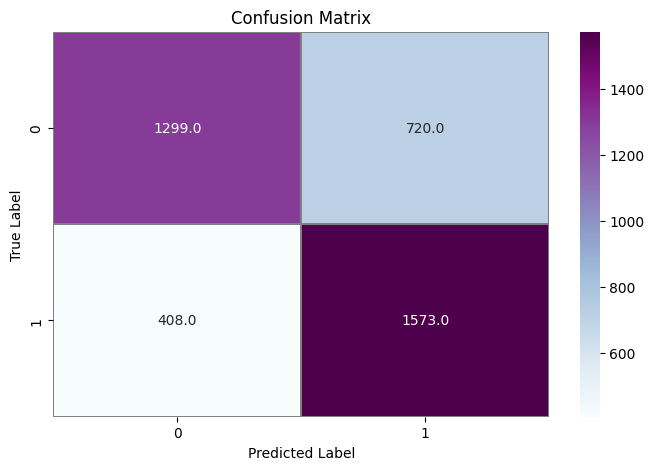

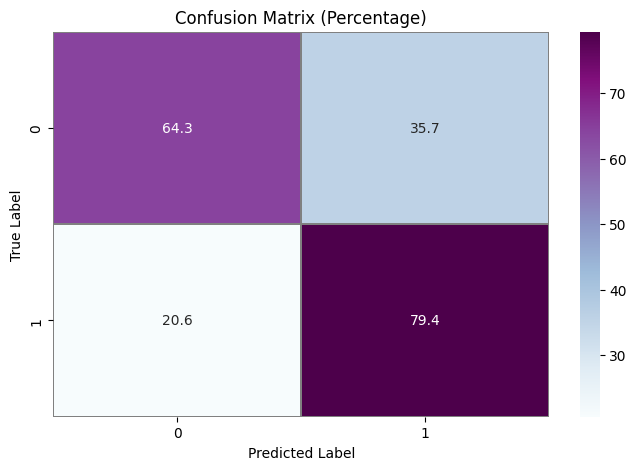

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7207 - loss: 1.8655
Test Loss: 1.8959860801696777
Test Accuracy: 0.7179999947547913


              precision    recall  f1-score   support

           0       0.76      0.64      0.70      2019
           1       0.69      0.79      0.74      1981

    accuracy                           0.72      4000
   macro avg       0.72      0.72      0.72      4000
weighted avg       0.72      0.72      0.72      4000



In [34]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = y_test 

confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print()
print()
print(classification_report(y_test, y_pred_classes))